# Engram Neural Network

Engram cells are:

* **Persistent:** Once activated during memory formation, they remain "tagged" as part of that memory.
* **Reactivatable:** They are reactivated during memory recall, even by partial cues.
* **Recurrent:** They are embedded in recurrent networks (especially in the hippocampus and cortex).
* **Hebbian:** Memory formation involves activity-dependent plasticity, i.e., Hebbian learning:
  * "Cells that fire together, wire together."
* **Sparse and Distributed:** Engram ensembles are not dense — they involve a small subset of neurons activated selectively.

* https://www.nature.com/articles/s41380-023-02137-5
* https://en.wikipedia.org/wiki/Engram_(neuropsychology)
* https://en.wikipedia.org/wiki/Multiple_trace_theory
* https://en.wikipedia.org/wiki/Sparse_distributed_memory
* https://en.wikipedia.org/wiki/Neuronal_memory_allocation
* https://en.wikipedia.org/wiki/Hebbian_theory
* https://en.wikipedia.org/wiki/Hopfield_network

In [1]:
%pip install tensorflow numpy matplotlib pandas seaborn scipy keras -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import keras
import numpy as np
import tensorflow as tf
from keras import layers, Model

class EngramLayer(layers.Layer):
    def __init__(self, memory_size, hidden_dim, **kwargs):
        super().__init__(**kwargs)
        self.memory_size = memory_size
        self.hidden_dim = hidden_dim

    def build(self, input_shape):
        # Initialize learnable memory bank
        self.memory_bank = self.add_weight(
            shape=(self.memory_size, self.hidden_dim),
            initializer="random_normal",
            trainable=True,
            name="engram_memory"
        )

    def call(self, z):
        # z: (batch_size, hidden_dim)
        z_norm = tf.nn.l2_normalize(z, axis=-1)
        memory_norm = tf.nn.l2_normalize(self.memory_bank, axis=-1)

        # Cosine similarity
        sim = tf.matmul(z_norm, memory_norm, transpose_b=True)
        weights = tf.nn.softmax(sim, axis=-1)

        # Weighted sum of memory traces
        retrieved = tf.matmul(weights, self.memory_bank)
        return retrieved

def build_engram_net(input_dim, hidden_dim, memory_size, output_dim):
    inputs = layers.Input(shape=(input_dim,))
    z = layers.Dense(hidden_dim, activation="tanh")(inputs)
    retrieved = EngramLayer(memory_size, hidden_dim)(z)
    combined = layers.Add()([z, retrieved])
    outputs = layers.Dense(output_dim)(combined)

    return Model(inputs, outputs)


E0000 00:00:1747751775.920576   16016 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747751775.931027   16016 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747751775.953105   16016 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747751775.953136   16016 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747751775.953139   16016 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747751775.953142   16016 computation_placer.cc:177] computation placer already registered. Please check linka

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Dummy data
x = np.random.randn(1000, 10).astype(np.float32)
y = x + 0.05 * np.random.randn(1000, 10).astype(np.float32)

# Model
model = build_engram_net(input_dim=10, hidden_dim=32, memory_size=16, output_dim=10)
model.compile(optimizer="adam", loss="mse")
model.summary()
model.fit(x, y, epochs=10, batch_size=32, validation_split=0.1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        352 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ engram_layer        │ (None, 32)        │        512 │ dense[0][0]       │
│ (EngramLayer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32)        │          0 │ dense[0][0],      │
│                     │                   │            │ engram_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │        330 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,194 (4.66 KB)

 Trainable params: 1,194 (4.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1864 - val_loss: 0.8264
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7979 - val_loss: 0.5469
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5337 - val_loss: 0.3588
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3554 - val_loss: 0.2341
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2366 - val_loss: 0.1523
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1580 - val_loss: 0.0995
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1068 - val_loss: 0.0664
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0742 - val_loss: 0.0465
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0542 - val_loss: 0.0352
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0425 - val_loss: 0.0293


In [6]:
class EngramCell(layers.Layer):
    def __init__(self, input_dim, hidden_dim, memory_size, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.memory_size = memory_size
        self.state_size = hidden_dim

    def build(self, input_shape):
        # Input encoder
        self.input_encoder = layers.Dense(self.hidden_dim, activation="tanh")

        # Hidden state integrator
        self.hidden_integrator = layers.Dense(self.hidden_dim, activation="tanh")

        # Output decoder
        self.decoder = layers.Dense(self.hidden_dim)

        # Memory Bank (Engrams)
        self.memory_bank = self.add_weight(
            shape=(self.memory_size, self.hidden_dim),
            initializer="glorot_uniform",
            trainable=True,
            name="engram_memory"
        )

    def call(self, inputs, states):
        prev_h = states[0]

        # Encode input
        z_t = self.input_encoder(inputs)

        # Retrieve engram via cosine similarity
        z_norm = tf.nn.l2_normalize(z_t, axis=-1)
        mem_norm = tf.nn.l2_normalize(self.memory_bank, axis=-1)

        sim = tf.matmul(z_norm, mem_norm, transpose_b=True)  # [batch, memory_size]
        weights = tf.nn.softmax(sim, axis=-1)
        m_t = tf.matmul(weights, self.memory_bank)  # [batch, hidden_dim]

        # Integrate memory with previous hidden state and current input
        combined = tf.concat([z_t, m_t, prev_h], axis=-1)
        h_t = self.hidden_integrator(combined)

        output = self.decoder(h_t)
        return output, [h_t]


In [7]:
def build_enn_sequence_model(input_dim, time_steps, hidden_dim, memory_size, output_dim):
    inputs = keras.Input(shape=(time_steps, input_dim))
    enn_cell = EngramCell(input_dim, hidden_dim, memory_size)
    rnn_layer = layers.RNN(enn_cell, return_sequences=True)
    rnn_output = rnn_layer(inputs)
    outputs = layers.TimeDistributed(layers.Dense(output_dim))(rnn_output)
    return keras.Model(inputs, outputs)


In [8]:
# Dummy sequence data
import numpy as np

time_steps = 10
input_dim = 8
hidden_dim = 32
output_dim = 8
memory_size = 16

x = np.random.randn(1000, time_steps, input_dim).astype(np.float32)
y = x + 0.1 * np.random.randn(1000, time_steps, input_dim).astype(np.float32)

model = build_enn_sequence_model(input_dim, time_steps, hidden_dim, memory_size, output_dim)
model.compile(optimizer="adam", loss="mse")
model.summary()
model.fit(x, y, batch_size=32, epochs=10, validation_split=0.1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, 10, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 8)          │           264 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 776 (3.03 KB)

 Trainable params: 776 (3.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.8443 - val_loss: 0.3592
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2885 - val_loss: 0.1229
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0976 - val_loss: 0.0466
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0436 - val_loss: 0.0398
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0387 - val_loss: 0.0372
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0363 - val_loss: 0.0351
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0343 - val_loss: 0.0333
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0325 - val_loss: 0.0317
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0309 - val_loss: 0.0303
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0295 - val_loss: 0.0289


## Enhancements

### Hebbian Plasticity:

* We'll implement a differentiable Hebbian update rule that reinforces memory patterns: $$\Delta M \propto z^T_t \cdot z_t$$ (or more generally: $pre \otimes post$, where both are the encoded input).
* We'll store a separate Hebbian trace, not just rely on learnable memory weights.
* The memory will be updated online at each time step.

### Sparsity Regularization

* We'll penalize dense engram retrieval by:
  * Adding a regularization loss on the attention weights (cosine similarity softmax).
  * Using entropy or L1 loss on attention weights to encourage sparse memory activation.
* This will encourage:
  * Selective memory retreival
  * Biological realism (sparse memory activation)
  * More interpretable Hebbian traces)

In [9]:
from keras.regularizers import Regularizer

class SparsityRegularizer(Regularizer):
    def __init__(self, strength=0.01):
        self.strength = strength

    def __call__(self, x):
        # L1 norm encourages sparsity
        return self.strength * tf.reduce_mean(tf.reduce_sum(tf.abs(x), axis=-1))

    def get_config(self):
        return {"strength": self.strength}


class EntropySparsityRegularizer(Regularizer):
    def __init__(self, strength=0.01, epsilon=1e-8):
        self.strength = strength
        self.epsilon = epsilon

    def __call__(self, x):
        x = tf.clip_by_value(x, self.epsilon, 1.0)
        entropy = -tf.reduce_sum(x * tf.math.log(x), axis=-1)
        return self.strength * tf.reduce_mean(entropy)

    def get_config(self):
        return {"strength": self.strength, "epsilon": self.epsilon}


In [10]:
class HebbianEngramCell(layers.Layer):
    def __init__(self, input_dim, hidden_dim, memory_size, hebbian_lr=0.05, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.memory_size = memory_size
        self.state_size = [hidden_dim, [memory_size, hidden_dim], [memory_size, hidden_dim]]  # h_t, hebbian_trace, memory_bank
        self.output_size = hidden_dim
        self.hebbian_lr = hebbian_lr  # Increased learning rate for Hebbian updates
        
    def build(self, input_shape):
        # Input encoder with larger initialization
        self.input_encoder = layers.Dense(
            self.hidden_dim, 
            activation="relu",  # Changed from tanh to ReLU for better gradient flow
            kernel_initializer="he_normal"  # Better initialization for ReLU
        )
        
        # Hidden state integrator
        self.hidden_integrator = layers.Dense(
            self.hidden_dim * 3, 
            activation="relu",  # Changed to ReLU
            kernel_initializer="he_normal"
        )
        self.output_dense = layers.Dense(
            self.hidden_dim, 
            activation="relu",  # Changed to ReLU
            kernel_initializer="he_normal"
        )
        
        # Output decoder
        self.decoder = layers.Dense(self.hidden_dim)
        
        # Memory Bank (Engrams) - initialized weights
        self.memory_bank = self.add_weight(
            shape=(self.memory_size, self.hidden_dim),
            initializer="glorot_uniform",
            trainable=True,
            name="engram_memory"
        )
        
        # Hebbian trace - initially small random values instead of zeros
        self.initial_hebbian_trace = self.add_weight(
            shape=(self.memory_size, self.hidden_dim),
            initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01),  # Small random init
            trainable=False,
            name="initial_hebbian_trace"
        )
        
        # Add layer normalization for better stability
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.built = True
        
    def call(self, inputs, states, training=None):
        # Unpack states: previous hidden state, hebbian trace, memory bank state
        prev_h = states[0]
        hebbian_trace = states[1]
        memory_bank_state = states[2]
        
        # Encode input with normalization
        z_t = self.input_encoder(inputs)
        z_t = self.layer_norm1(z_t)  # Normalize activations
        
        # Combine memory bank and hebbian trace with scaling to prevent dominance
        # Scale hebbian trace to be proportionate to memory weights
        scale_factor = 0.5  # Balance between learned weights and Hebbian trace
        effective_memory = memory_bank_state + scale_factor * hebbian_trace
        
        # Retrieve engram via cosine similarity
        z_norm = tf.nn.l2_normalize(z_t, axis=-1)  # [batch, hidden_dim]
        mem_norm = tf.nn.l2_normalize(effective_memory, axis=-1)  # [memory_size, hidden_dim]
        
        # Add temperature to softmax to prevent saturation
        temperature = 1.5  # Higher temperature = softer attention distribution
        sim = tf.matmul(z_norm, mem_norm, transpose_b=True)  # [batch, memory_size]
        attention_weights = tf.nn.softmax(sim / temperature, axis=-1)
        
        # Retrieved memory
        m_t = tf.matmul(attention_weights, effective_memory)  # [batch, hidden_dim]
        
        # Integrate memory with previous hidden state and current input
        combined = tf.concat([z_t, m_t, prev_h], axis=-1)
        combined_hidden = self.hidden_integrator(combined)
        h_t = self.output_dense(combined_hidden)
        h_t = self.layer_norm2(h_t)  # Normalize hidden state
        
        # Apply Hebbian learning with modified update rule
        # Use stabilized Hebbian rule: pre-synaptic * post-synaptic - decay * trace
        hebbian_update = tf.einsum('bi,bj->bij', attention_weights, z_t)  # [batch, memory_size, hidden_dim]
        mean_update = tf.reduce_mean(hebbian_update, axis=0)  # [memory_size, hidden_dim]
        
        # Add gradient noise for exploration and to prevent getting stuck
        noise = tf.random.normal(
            shape=mean_update.shape, 
            mean=0.0, 
            stddev=0.001,
            dtype=mean_update.dtype
        )
        
        # Update Hebbian trace with noise and anti-decay term
        decay_rate = 1.0 - self.hebbian_lr
        new_hebbian_trace = hebbian_trace * decay_rate + self.hebbian_lr * (mean_update + noise)
        
        # Clip to prevent explosion
        new_hebbian_trace = tf.clip_by_value(new_hebbian_trace, -0.1, 0.1)
        
        # Return updated states
        return h_t, [h_t, new_hebbian_trace, memory_bank_state]
        
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if batch_size is None and inputs is not None:
            batch_size = tf.shape(inputs)[0]
            
        # Initial hidden state is small random values
        initial_h = tf.random.normal([batch_size, self.hidden_dim], mean=0.0, stddev=0.01, dtype=dtype or tf.float32)
        
        # Initial hebbian trace is small random values
        initial_hebbian = tf.random.normal([self.memory_size, self.hidden_dim], mean=0.0, stddev=0.01, dtype=dtype or tf.float32)
        
        # Initial memory bank state is the learned memory bank weights
        initial_memory_bank = self.memory_bank
        
        return [initial_h, initial_hebbian, initial_memory_bank]

In [11]:
# FIXME: This code is more biologically plausible
# but not yet fully functional or as useful for DL tasks.
"""
class HebbianEngramCell(layers.Layer):
    def __init__(self, input_dim, hidden_dim, memory_size, hebbian_lr=0.05, 
                 sparsity_level=0.1, inhibition_strength=0.5, 
                 neuromodulation_strength=0.2, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.memory_size = memory_size
        self.state_size = [hidden_dim, [memory_size, hidden_dim], [memory_size, hidden_dim], hidden_dim]  # h_t, hebbian_trace, memory_bank, neuromodulation
        self.output_size = hidden_dim
        self.hebbian_lr = hebbian_lr  # Learning rate for Hebbian updates
        self.sparsity_level = sparsity_level  # Target sparsity level for activations
        self.inhibition_strength = inhibition_strength  # Lateral inhibition strength
        self.neuromodulation_strength = neuromodulation_strength  # How strongly neuromodulators affect learning
        
    def build(self, input_shape):
        # Input encoder - Dendrites
        self.input_encoder = layers.Dense(
            self.hidden_dim, 
            activation=None,  # Linear activation initially
            kernel_initializer="glorot_uniform"
        )
        
        # Recurrent connections - Local circuits
        self.recurrent_kernel = self.add_weight(
            shape=(self.hidden_dim, self.hidden_dim),
            initializer="glorot_uniform",
            trainable=True,
            name="recurrent_kernel"
        )
        
        # Memory Bank (Engrams) - consolidated memory traces
        self.memory_bank = self.add_weight(
            shape=(self.memory_size, self.hidden_dim),
            initializer="glorot_uniform",
            trainable=True,
            name="engram_memory"
        )
        
        # Hebbian trace - short-term plasticity
        self.initial_hebbian_trace = self.add_weight(
            shape=(self.memory_size, self.hidden_dim),
            initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01),
            trainable=False,
            name="initial_hebbian_trace"
        )
        
        # Inhibitory connections - biological lateral inhibition
        self.inhibitory_kernel = self.add_weight(
            shape=(self.hidden_dim, self.hidden_dim),
            initializer=keras.initializers.RandomUniform(minval=0, maxval=0.1),
            trainable=True,
            name="inhibitory_kernel"
        )
        
        # Consolidation weights - memory consolidation in the hippocampus
        self.consolidation_weights = self.add_weight(
            shape=(self.hidden_dim, self.memory_size),
            initializer="glorot_uniform",
            trainable=True,
            name="consolidation_weights"
        )
        
        # Threshold for activation - neuronal firing threshold
        self.activation_threshold = self.add_weight(
            shape=(self.hidden_dim,),
            initializer=keras.initializers.Constant(0.1),
            trainable=True,
            name="activation_threshold"
        )
        
        # Neuromodulatory system - processes like "surprise" or "importance" signals
        self.neuromodulatory_encoder = layers.Dense(
            self.hidden_dim,
            activation="sigmoid",
            kernel_initializer="glorot_uniform",
            name="neuromodulatory_encoder"
        )
        
        # Metaplasticity weights - control learning rates in different memory regions
        self.metaplasticity_weights = self.add_weight(
            shape=(self.memory_size,),
            initializer=keras.initializers.Constant(1.0),
            trainable=True,
            name="metaplasticity_weights"
        )
        
        self.built = True
        
    def call(self, inputs, states, training=None):
        # Unpack states: previous hidden state, hebbian trace, memory bank state, neuromodulation state
        prev_h = states[0]
        hebbian_trace = states[1]
        memory_bank_state = states[2]
        neuromodulation = states[3]  # Previous neuromodulatory state
        
        # Encode input - dendrites receiving signals
        z_t = self.input_encoder(inputs)
        
        # Apply recurrent connections - local circuit activity
        recurrent_input = tf.matmul(prev_h, self.recurrent_kernel)
        
        # Compute prediction error for neuromodulation (surprise signal)
        # High values indicate unexpected input patterns
        prediction = recurrent_input + memory_bank_state  # What the network expects
        prediction_error = tf.reduce_mean(tf.abs(z_t - prediction), axis=-1, keepdims=True)
        
        # Update neuromodulation state based on prediction error
        # This models dopamine, acetylcholine, and norepinephrine systems that respond to novelty
        new_neuromodulation = self.neuromodulatory_encoder(
            tf.concat([prediction_error, prev_h, z_t], axis=-1)
        )
        
        # Combine memory bank and hebbian trace - memory recall
        # Modulate with neuromodulation strength
        modulation_factor = 0.5 + self.neuromodulation_strength * new_neuromodulation
        effective_memory = memory_bank_state + modulation_factor * hebbian_trace
        
        # Retrieve engram via biological similarity functions
        memory_activation = self._compute_memory_match(z_t, effective_memory)
        
        # Apply lateral inhibition - winner-take-all dynamics
        inhibitory_signals = tf.matmul(prev_h, self.inhibitory_kernel)
        
        # Sum all inputs to neuron - membrane potential
        membrane_potential = z_t + recurrent_input + memory_activation - self.inhibition_strength * inhibitory_signals
        
        # Apply activation threshold and nonlinearity - action potential
        h_t = self._activate_with_threshold(membrane_potential)
        
        # Apply Hebbian learning with neuromodulation - synaptic plasticity
        # Neuromodulation affects learning rate based on "importance" of the current input
        effective_lr = self.hebbian_lr * (1.0 + self.neuromodulation_strength * new_neuromodulation)
        new_hebbian_trace = self._update_hebbian_trace(hebbian_trace, h_t, memory_bank_state, effective_lr)
        
        # Return updated states
        return h_t, [h_t, new_hebbian_trace, memory_bank_state, new_neuromodulation]
        
    def _compute_memory_match(self, current_activity, memories):
        # Normalize activities for cosine similarity
        current_norm = tf.nn.l2_normalize(current_activity, axis=-1)
        memories_norm = tf.nn.l2_normalize(memories, axis=-1)
        
        # Compute similarity
        similarity = tf.matmul(current_norm, memories_norm, transpose_b=True)
        
        # Apply soft winner-take-all competition (sparse activation)
        # This mimics competitive processes in memory retrieval
        activation_winners = self._sparse_softmax(similarity, sparsity=self.sparsity_level)
        
        # Weight memory content by activation
        retrieved_memories = tf.matmul(activation_winners, memories)
        
        return retrieved_memories
        
    def _sparse_softmax(self, x, sparsity=0.1):
        "" "Implements a sparse softmax activation that only activates top k% values." ""
        batch_size = tf.shape(x)[0]
        
        # Get the values that would represent the top k% threshold
        k = tf.cast(tf.math.ceil(tf.cast(tf.shape(x)[1], tf.float32) * sparsity), tf.int32)
        values, _ = tf.math.top_k(x, k=k)
        
        # Get the k-th value (threshold)
        thresholds = tf.reduce_min(values, axis=1, keepdims=True)
        
        # Create a mask for values above threshold
        mask = tf.cast(x >= thresholds, tf.float32)
        
        # Apply softmax only to values above threshold
        x_exp = tf.exp(x) * mask
        x_sum = tf.reduce_sum(x_exp, axis=1, keepdims=True)
        return x_exp / (x_sum + 1e-10)
        
    def _activate_with_threshold(self, x):
        "" "Apply thresholded activation, mimicking neuronal firing threshold." ""
        # ReLU with learnable threshold
        above_threshold = tf.nn.relu(x - self.activation_threshold)
        
        # Apply gain control - neuronal homeostasis
        total_activation = tf.reduce_sum(above_threshold, axis=-1, keepdims=True) + 1e-10
        target_activation = 0.1 * self.hidden_dim  # Target 10% activation rate
        gain_factor = target_activation / total_activation
        
        # Apply homeostatic gain control with gradient stopping to prevent instability
        gain = tf.stop_gradient(gain_factor) + 1.0 - tf.stop_gradient(tf.ones_like(gain_factor))
        
        return above_threshold * gain
        
    def _update_hebbian_trace(self, hebbian_trace, post_synaptic, memory, effective_lr=None):
        "" "Update Hebbian trace with biologically plausible rule and metaplasticity." ""
        # Use the default learning rate if none provided
        if effective_lr is None:
            effective_lr = self.hebbian_lr
            
        # Expand dimensions for broadcasting
        if len(effective_lr.shape) == 2:
            effective_lr = tf.reduce_mean(effective_lr, axis=-1, keepdims=True)
            
        # Apply metaplasticity - different memory regions have different plasticity
        region_specific_lr = effective_lr * tf.reshape(self.metaplasticity_weights, [1, self.memory_size, 1])
        
        # Consolidation signal - determines what gets added to memory
        consolidation = tf.matmul(post_synaptic, self.consolidation_weights)
        
        # Hebbian update: pre-synaptic * post-synaptic - decay * trace
        decay_rate = 1.0 - region_specific_lr
        
        # Compute which memory cells should be updated based on consolidation signal
        update_mask = tf.expand_dims(consolidation, -1)
        
        # Compute updates based on post-synaptic activity
        post_expanded = tf.expand_dims(post_synaptic, 1)  
        # Broadcast to match memory shape
        update = update_mask * post_expanded
        
        # Apply STDP-inspired learning rule with time decay
        new_trace = hebbian_trace * decay_rate + region_specific_lr * update
        
        # Clip to prevent explosion - biophysical constraint
        new_trace = tf.clip_by_value(new_trace, -0.1, 0.1)
        
        return new_trace
        
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if batch_size is None and inputs is not None:
            batch_size = tf.shape(inputs)[0]
            
        # Initial hidden state - resting potential
        initial_h = tf.zeros([batch_size, self.hidden_dim], dtype=dtype or tf.float32)
        
        # Initial hebbian trace - no prior learning
        initial_hebbian = tf.zeros([self.memory_size, self.hidden_dim], dtype=dtype or tf.float32)
        
        # Initial memory bank state - consolidated memories
        initial_memory_bank = self.memory_bank
        
        # Initial neuromodulation state - baseline neuromodulator levels
        initial_neuromodulation = tf.zeros([batch_size, self.hidden_dim], dtype=dtype or tf.float32)
        
        return [initial_h, initial_hebbian, initial_memory_bank, initial_neuromodulation]
"""

'\nclass HebbianEngramCell(layers.Layer):\n    def __init__(self, input_dim, hidden_dim, memory_size, hebbian_lr=0.05, \n                 sparsity_level=0.1, inhibition_strength=0.5, \n                 neuromodulation_strength=0.2, **kwargs):\n        super().__init__(**kwargs)\n        self.input_dim = input_dim\n        self.hidden_dim = hidden_dim\n        self.memory_size = memory_size\n        self.state_size = [hidden_dim, [memory_size, hidden_dim], [memory_size, hidden_dim], hidden_dim]  # h_t, hebbian_trace, memory_bank, neuromodulation\n        self.output_size = hidden_dim\n        self.hebbian_lr = hebbian_lr  # Learning rate for Hebbian updates\n        self.sparsity_level = sparsity_level  # Target sparsity level for activations\n        self.inhibition_strength = inhibition_strength  # Lateral inhibition strength\n        self.neuromodulation_strength = neuromodulation_strength  # How strongly neuromodulators affect learning\n\n    def build(self, input_shape):\n        #

In [12]:
def build_hebbian_engram_model(input_dim, time_steps, hidden_dim, memory_size, output_dim, hebbian_lr=0.01):
    # Create a custom model that tracks internal states
    class HebbianEngramModel(keras.Model):
        def __init__(self, cell, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.cell = cell
            self.states = None
        
        def train_step(self, data):
            x, y = data
            
            # Initialize state if needed
            if self.states is None:
                self.states = self.cell.get_initial_state(
                    batch_size=tf.shape(x)[0], 
                    dtype=tf.float32
                )
            
            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)
                loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
            # Update metrics
            self.compiled_metrics.update_state(y, y_pred)
            return {m.name: m.result() for m in self.metrics}
        
        def get_hebbian_trace(self):
            # Return the current hebbian trace from the stored states
            if self.states is None:
                return None
            return self.states[1]

    # Build the model
    inputs = keras.Input(shape=(time_steps, input_dim))
    hebbian_cell = HebbianEngramCell(input_dim, hidden_dim, memory_size, hebbian_lr)
    rnn_layer = layers.RNN(hebbian_cell, return_sequences=True, return_state=True)
    rnn_output_and_states = rnn_layer(inputs)
    
    # Extract the output sequence
    rnn_output = rnn_output_and_states[0]
    outputs = layers.TimeDistributed(layers.Dense(output_dim))(rnn_output)
    
    # Create the model
    model = HebbianEngramModel(hebbian_cell, inputs=inputs, outputs=outputs)
    return model, rnn_layer

In [13]:
class HebbianTraceCallback(keras.callbacks.Callback):
    # Callback to monitor the Hebbian trace during training
    # Hebbian trace refers to the internal state of the Hebbian learning mechanism
    def __init__(self, x_train, verbose=True):
        super().__init__()
        self.hebbian_traces = []
        self.x_train = x_train  # Maybe x_train[:100]?
        self.verbose = verbose
        
    def on_epoch_end(self, epoch, logs=None):
        # Get a batch of data to run through the model
        x_sample = self.x_train[:32]  # Use a small batch
        
        # Create new initial states
        initial_states = self.model.cell.get_initial_state(
            batch_size=tf.shape(x_sample)[0],
            dtype=tf.float32
        )
        
        # Run the RNN layer with the sample data
        rnn_layer = [layer for layer in self.model.layers if isinstance(layer, keras.layers.RNN)][0]
        outputs, *states = rnn_layer(x_sample, initial_state=initial_states, training=False)
        
        # Store the hebbian trace (states[1] would be the hebbian trace state)
        hebbian_trace = states[1]
        self.hebbian_traces.append(hebbian_trace.numpy())
        
        # Print stats about the hebbian trace
        if self.verbose:
            print(f" Hebbian trace - min: {np.min(hebbian_trace):.6f}, max: {np.max(hebbian_trace):.6f}, mean: {np.mean(np.abs(hebbian_trace)):.6f}")

In [14]:
from keras.losses import MeanSquaredError

# Simplify the combined_loss function to only compute MSE
def combined_loss(y_true, y_pred):
    mse = MeanSquaredError()
    return mse(y_true, y_pred)

# Train the model on the dummy dataset
# Ensure initial states are passed to the RNN layer during training
hebbian_model, rnn_layer = build_hebbian_engram_model(
    input_dim=input_dim,
    time_steps=time_steps,
    hidden_dim=hidden_dim,
    memory_size=memory_size,
    output_dim=output_dim,
    hebbian_lr=0.01
)

# Compile and fit
hebbian_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=combined_loss
)

# Use a smaller subset for faster training
train_size = 800
val_size = 200
x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:train_size+val_size], y[train_size:train_size+val_size]

# Initialize states explicitly (if needed for debugging or visualization)
initial_states = rnn_layer.cell.get_initial_state(inputs=x_train, batch_size=32, dtype=tf.float32)

trace_callback = HebbianTraceCallback(x_train)

# Train the model
history = hebbian_model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[trace_callback]
)

# Plot the model summary
hebbian_model.summary()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182  Hebbian trace - min: -0.029373, max: 0.029252, mean: 0.007795
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0172 - val_loss: 0.6576
Epoch 2/10
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0218 Hebbian trace - min: -0.026466, max: 0.023417, mean: 0.007390
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0202 - val_loss: 0.4276
Epoch 3/10
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 Hebbian trace - min: -0.030137, max: 0.024823, mean: 0.006627
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0077 - val_loss: 0.3019
Epoch 4/10
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 Hebbian trace - min: -0.028428, max: 0.029208, mean: 0.007305
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0057 - val_loss: 0.2336
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 Hebbian trace - min: -0.025664, max: 0.028909, mean: 0.007764
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046 - val_loss: 

Model: "hebbian_engram_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ [(None, 10, 32),       │        13,856 │
│                                 │ (None, 32), (None,     │               │
│                                 │ 16), (None, 32),       │               │
│                                 │ (None, 16), (None,     │               │
│                                 │ 32)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 8)          │           264 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,338 (161.48 KB)

 Trainable params: 13,608 (53.16 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 27,218 (106.32 KB)

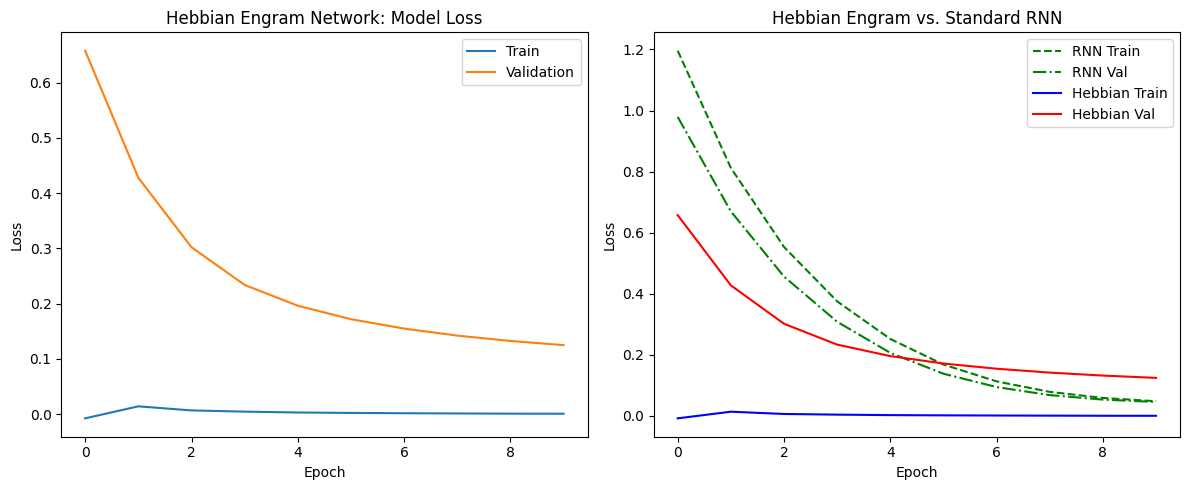

In [15]:
# Plot the learning signal and evaluate model performance
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Hebbian Engram Network: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Compare with standard RNN performance
standard_rnn = keras.Sequential([
    keras.layers.Input(shape=(time_steps, input_dim)),
    keras.layers.SimpleRNN(hidden_dim, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(output_dim))
])

standard_rnn.compile(optimizer='adam', loss='mse')
standard_hist = standard_rnn.fit(x_train, y_train, epochs=10, batch_size=32, 
                             validation_data=(x_val, y_val), verbose=0)

plt.subplot(1, 2, 2)
plt.plot(standard_hist.history['loss'], 'g--')
plt.plot(standard_hist.history['val_loss'], 'g-.')
plt.plot(history.history['loss'], 'b-')
plt.plot(history.history['val_loss'], 'r-')
plt.title('Hebbian Engram vs. Standard RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['RNN Train', 'RNN Val', 'Hebbian Train', 'Hebbian Val'], loc='upper right')

plt.tight_layout()
plt.show()

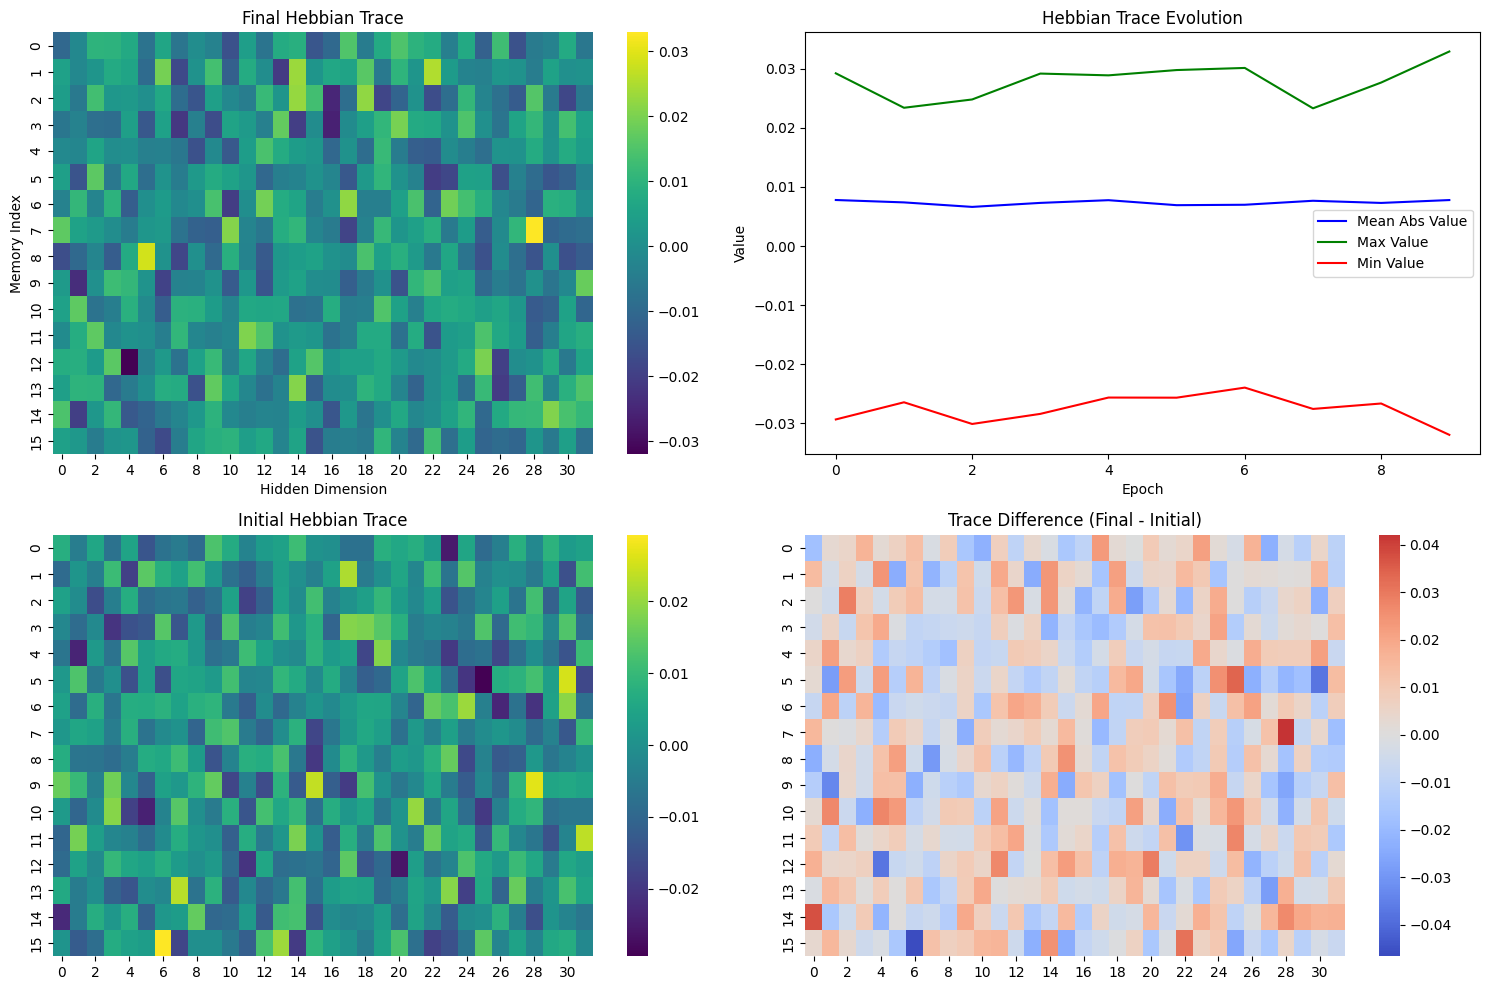

In [16]:
def plot_hebbian_trace(trace_callback):
    # Plot the Hebbian trace evolution over epochs
    plt.figure(figsize=(15, 10))

    # Plot the last hebbian trace as a heatmap
    plt.subplot(2, 2, 1)
    last_trace = trace_callback.hebbian_traces[-1]  # Get the last trace
    sns.heatmap(last_trace, cmap='viridis')
    plt.title('Final Hebbian Trace')
    plt.xlabel('Hidden Dimension')
    plt.ylabel('Memory Index')

    # Plot the evolution of hebbian trace values
    plt.subplot(2, 2, 2)
    trace_means = [np.mean(np.abs(trace)) for trace in trace_callback.hebbian_traces]
    trace_maxs = [np.max(trace) for trace in trace_callback.hebbian_traces]
    trace_mins = [np.min(trace) for trace in trace_callback.hebbian_traces]
    plt.plot(trace_means, 'b-', label='Mean Abs Value')
    plt.plot(trace_maxs, 'g-', label='Max Value')
    plt.plot(trace_mins, 'r-', label='Min Value')
    plt.title('Hebbian Trace Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    # Plot the first vs last trace for comparison
    if len(trace_callback.hebbian_traces) > 1:
        plt.subplot(2, 2, 3)
        first_trace = trace_callback.hebbian_traces[0]
        sns.heatmap(first_trace, cmap='viridis')
        plt.title('Initial Hebbian Trace')
        
        # Plot the difference between first and last
        plt.subplot(2, 2, 4)
        diff = last_trace - first_trace
        sns.heatmap(diff, cmap='coolwarm', center=0)
        plt.title('Trace Difference (Final - Initial)')

    plt.tight_layout()
    plt.show()


plot_hebbian_trace(trace_callback)

In [17]:
# Benchmark the model on an actual dataset and compare against a standard RNN, LSTM, and GRU
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
scaler = MinMaxScaler()
x_train = x_train.reshape(-1, 28 * 28).astype(np.float32) / 255.0  # Normalize to [0,1] range
x_test = x_test.reshape(-1, 28 * 28).astype(np.float32) / 255.0

# Apply scaler for additional normalization
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Reshape the data back to 28x28 for time steps (treating each row as a time step)
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

# For the output, we only need one prediction per image, so we'll use the final time step prediction
# This is different from before where we repeated the label across all time steps
# We'll use TimeDistributed to get outputs at each step, but only use the last one for loss calculation

# Split validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

# Define a custom attention layer to replace direct tf.nn operations
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.attention_dense = layers.Dense(1, activation='tanh')
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, inputs):
        # Compute attention weights
        attention_weights = self.attention_dense(inputs)  # [batch, time_steps, 1]
        attention_weights = keras.activations.softmax(attention_weights, axis=1)
        
        # Apply attention weights to input
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        return context_vector

# Define a custom model for sequence classification
def build_hebbian_engram_classifier(input_dim, time_steps, hidden_dim, memory_size, output_dim, hebbian_lr=0.05):
    # Create a custom model that handles sequences properly for classification
    class HebbianEngramClassifier(keras.Model):
        def __init__(self, cell, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.cell = cell
            self.states = None
        
        def train_step(self, data):
            x, y = data
            
            with tf.GradientTape() as tape:
                # Forward pass with fresh states each batch for better training
                self.states = self.cell.get_initial_state(
                    batch_size=tf.shape(x)[0], 
                    dtype=tf.float32
                )
                
                y_pred = self(x, training=True)
                # Get predictions from last time step for classification
                loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            
            # Apply gradient clipping to prevent exploding gradients
            gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
            
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
            # Update metrics
            self.compiled_metrics.update_state(y, y_pred)
            return {m.name: m.result() for m in self.metrics}
            # metrics_results = {m.name: m.result() for m in self.metrics}
            # metrics_results['loss'] = loss
            # return metrics_results
        
        def get_hebbian_trace(self):
            if self.states is None:
                return None
            return self.states[1]
    
    # Build the model
    inputs = keras.Input(shape=(time_steps, input_dim))
    
    # Create the Hebbian Cell with the improved parameters
    hebbian_cell = HebbianEngramCell(
        input_dim=input_dim, 
        hidden_dim=hidden_dim, 
        memory_size=memory_size, 
        hebbian_lr=hebbian_lr
    )
    
    # Stack RNN layers for better feature extraction
    rnn_layer = layers.RNN(hebbian_cell, return_sequences=True, return_state=True)
    rnn_output_and_states = rnn_layer(inputs)
    
    # Extract the output sequence
    rnn_output = rnn_output_and_states[0]  # Shape: [batch, time_steps, hidden_dim]
    
    # Use custom attention layer instead of direct tf operations
    context = AttentionLayer()(rnn_output)
    
    # Add a dropout layer to prevent overfitting
    dropout = layers.Dropout(0.3)(context)
    
    # Final classification layer
    outputs = layers.Dense(output_dim, activation='softmax')(dropout)
    
    # Create the model
    model = HebbianEngramClassifier(hebbian_cell, inputs=inputs, outputs=outputs)
    return model, rnn_layer

# Create the MNIST classifier
mnist_model, rnn_layer = build_hebbian_engram_classifier(
    input_dim=28,
    time_steps=28,
    hidden_dim=128,
    memory_size=64,  # Increased memory size
    output_dim=10,
    hebbian_lr=0.05  # Higher learning rate for Hebbian updates
)

# Create an early stopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Reduce learning rate when plateauing
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Initialize the Hebbian trace callback
trace_callback = HebbianTraceCallback(x_train[:100])  # Use a smaller subset for trace visualization

# Compile the model with appropriate loss and metrics
mnist_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
mnist_model.summary()

# Train the model
history = mnist_model.fit(
    x_train, y_train,
    batch_size=128,  # Larger batch size for stability
    epochs=15,  # Train for more epochs
    validation_data=(x_val, y_val),
    callbacks=[trace_callback, early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the model
print("\nRunning evaluation on test data...")
test_loss, test_acc = mnist_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Training data shape: (54000, 28, 28)
Validation data shape: (6000, 28, 28)
Test data shape: (10000, 28, 28)


Model: "hebbian_engram_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_2 (RNN)                     │ [(None, 28, 128),      │        16,384 │
│                                 │ (None, 128), (None,    │               │
│                                 │ 64), (None, 128),      │               │
│                                 │ (None, 64), (None,     │               │
│                                 │ 128)]                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,803 (69.54 KB)

 Trainable params: 9,611 (37.54 KB)

 Non-trainable params: 8,192 (32.00 KB)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7137 - loss: 0.1000 Hebbian trace - min: -0.014772, max: 0.035617, mean: 0.004665
422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 185ms/step - accuracy: 0.7140 - loss: 0.1000 - val_accuracy: 0.9458 - val_loss: 0.1959 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9547 - loss: 0.1000 Hebbian trace - min: -0.012349, max: 0.027824, mean: 0.004423
422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 151ms/step - accuracy: 0.9547 - loss: 0.1000 - val_accuracy: 0.9675 - val_loss: 0.1118 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9665 - loss: 0.1000 Hebbian trace - min: -0.012453, max: 0.028728, mean: 0.004273
422/422 ━━━━━━━━━━━━━━━━━━━━ 72s 171ms/step - accuracy: 0.9665 - loss: 0.1000 - val_accuracy: 0.9702 - val_loss: 0.1009 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9727 - loss: 0.1000 Hebbian trace - min: -0.011735

In [18]:
# Make predictions
y_pred = mnist_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
# y_true_classes = np.argmax(y_test, axis=2)[:,0]  # Take the first time step label (they're all the same)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


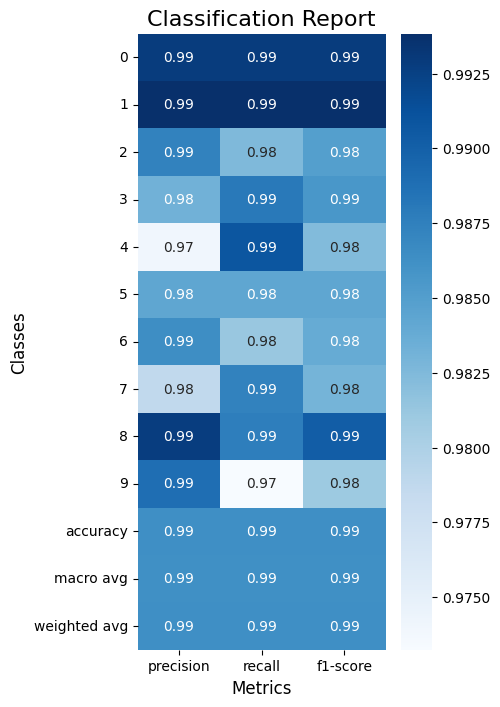

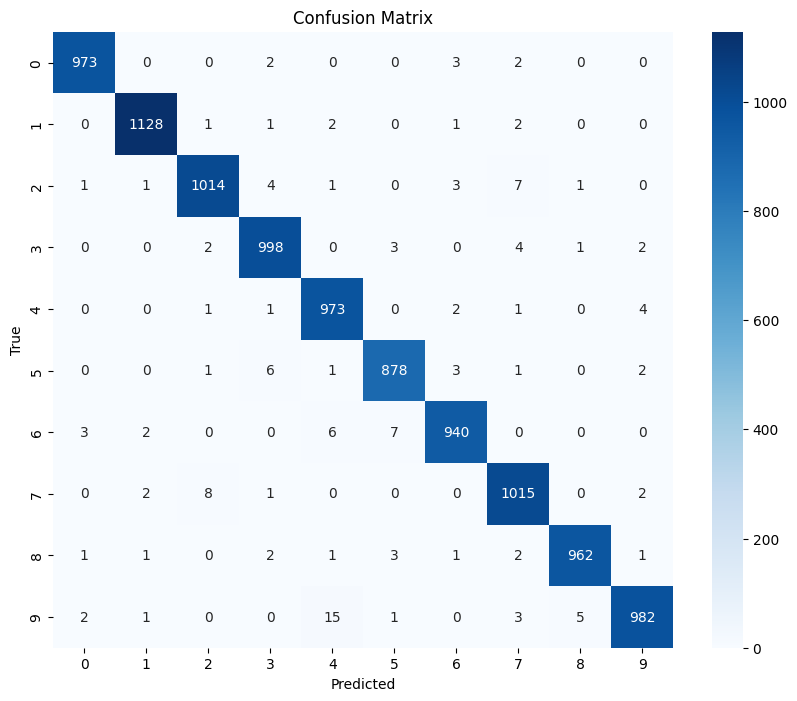

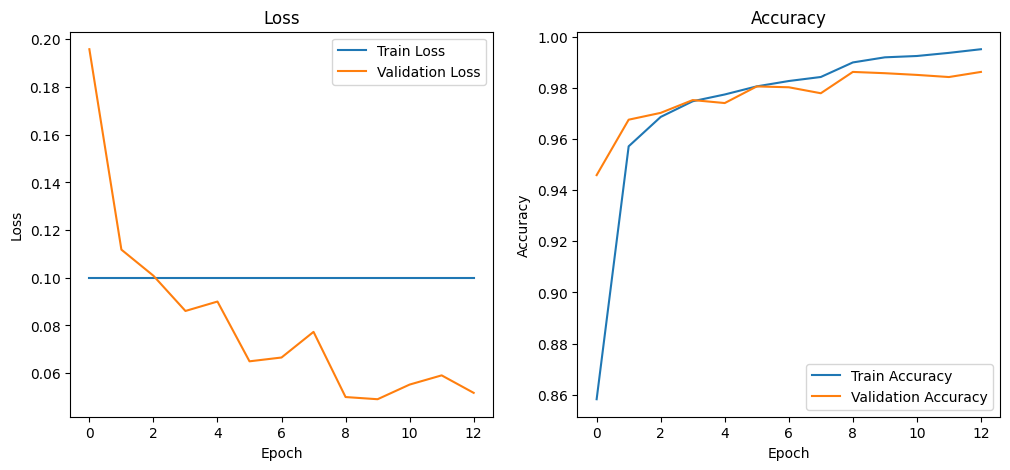

In [19]:
# Classification report
# print(classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)]))
report = classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)], output_dict=True)
df = pd.DataFrame(report)  #.transpose()
fig, ax = plt.subplots(figsize=(len(df), 8))
sns.heatmap(df.iloc[:-1, :].T, annot=True, fmt='.2f', cmap='Blues', ax=ax)
# plt.title('Classification Report')
ax.set_title("Classification Report", fontsize=16)
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Classes", fontsize=12)
plt.show()


# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
hebbian_model.save('hebbian_engram_model.h5')

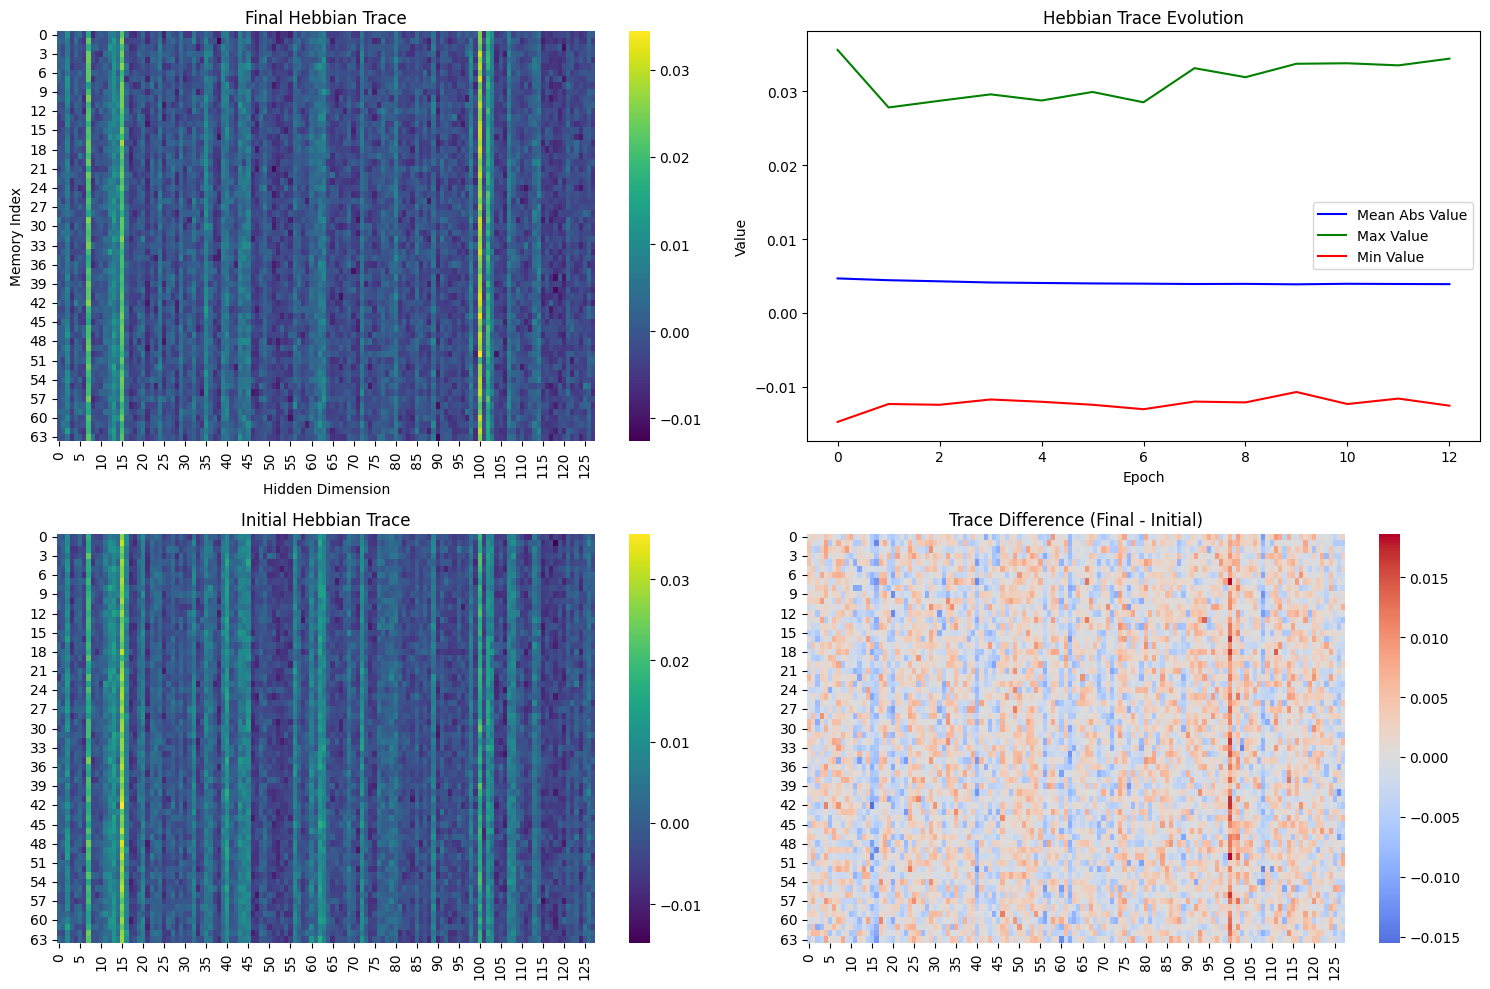

In [20]:
plot_hebbian_trace(trace_callback)